# Phillip Tan: k-NN Strikes Back!

In [1]:
#habitual imports
from __future__ import print_function, division
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 25) 
pd.set_option('display.precision', 3) 

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')

In [3]:
import time
from datetime import datetime as dt

## Data gathering

In [4]:
df = pd.read_csv('data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88042 entries, 0 to 88041
Data columns (total 4 columns):
latitude       88042 non-null float64
longitude      88042 non-null float64
close_date     88042 non-null object
close_price    88042 non-null float64
dtypes: float64(3), object(1)
memory usage: 2.7+ MB


In [6]:
df.head()

,latitude,longitude,close_date,close_price
0,1.502,86.351,2014-08-16 22:25:31.925431,1.302e+06
1,36.367,-98.664,2014-08-05 06:34:00.165876,1.475e+05
2,36.599,-97.925,2014-08-12 23:48:00.887510,1.374e+05
3,67.995,64.689,2014-08-17 05:27:01.404296,-1.411e+04
4,36.648,-97.866,2014-08-09 04:00:40.358242,2.391e+05


In [7]:
df['close_date'] = pd.to_datetime(df.close_date, format='%Y-%m-%d %H:%M:%S') 

In [8]:
df.info() #sanity check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88042 entries, 0 to 88041
Data columns (total 4 columns):
latitude       88042 non-null float64
longitude      88042 non-null float64
close_date     88042 non-null datetime64[ns]
close_price    88042 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 2.7 MB


## Explore the data

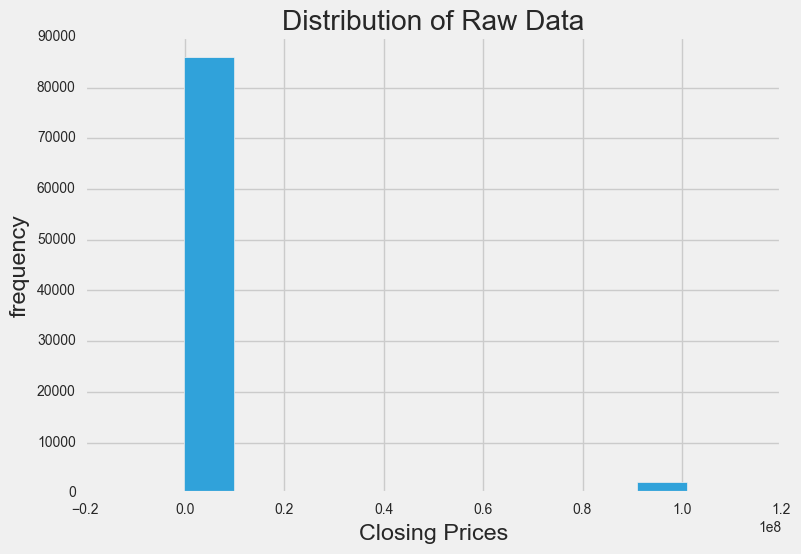

In [9]:
plt.hist(df['close_price'])
plt.title('Distribution of Raw Data')
plt.xlabel('Closing Prices')
plt.ylabel('frequency');

#it's evident that there are some negative values.
#most of the data falls within a given range
#there's another subset of data away from the majority

In [10]:
print('Total Datapoints: ' + str(len(df)))
print('Negative Close Prices: ' + str(len(df[df.close_price < 0])))
print('Outlier Close Prices: ' + str(len(df[df.close_price > 1000000])))

Total Datapoints: 88042
Negative Close Prices: 2174
Outlier Close Prices: 3197


In [11]:
cleaned_df = df[(df.close_price > 0) & (df.close_price < 1000000)].reset_index(drop=True)

In [12]:
print('Total Usable Datapoints: ' + str(len(cleaned_df)))

Total Usable Datapoints: 82671


In [13]:
cleaned_df.tail()

,latitude,longitude,close_date,close_price
82666,36.705,-98.158,2015-08-26 16:32:40.090264,242780.987
82667,36.212,-98.059,2014-09-16 10:56:59.521584,29364.461
82668,36.393,-98.629,2014-08-13 00:18:38.736704,193464.551
82669,36.499,-97.882,2015-02-21 15:48:06.541742,237266.003
82670,36.131,-98.223,2015-01-05 18:41:34.073452,168470.365


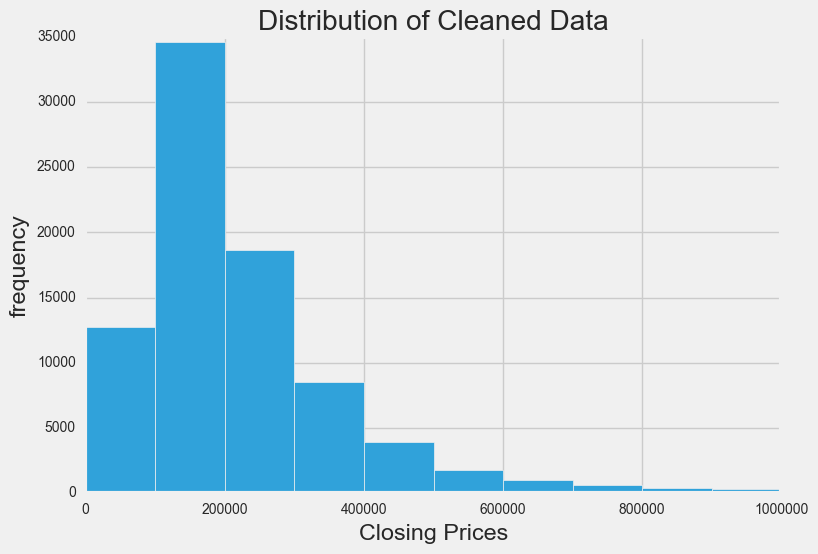

In [14]:
plt.hist(cleaned_df.close_price)
plt.title('Distribution of Cleaned Data')
plt.xlabel('Closing Prices')
plt.ylabel('frequency');

In [15]:
#sort by datetime so we can choose the newest homes as our testing set.
dataframe = cleaned_df.sort_values(by='close_date').reset_index(drop=True)

In [16]:
dataframe.head()

,latitude,longitude,close_date,close_price
0,36.162,-98.123,2013-12-31 04:47:10.005660,56935.085
1,36.482,-98.051,2014-01-01 01:58:30.098593,481654.393
2,36.278,-98.958,2014-01-04 01:13:42.187433,169432.247
3,-86.328,139.709,2014-01-05 13:29:17.311107,261704.565
4,36.727,-98.415,2014-01-05 20:11:02.713740,130798.555


In [17]:
dataframe.tail()

,latitude,longitude,close_date,close_price
82666,36.691,-98.267,2015-12-31 13:52:56.792281,187080.636
82667,35.720,-99.479,2016-01-01 19:46:09.393633,76330.016
82668,36.373,-99.786,2016-01-01 23:18:10.342554,149902.445
82669,36.223,-98.407,2016-01-03 12:15:47.651509,117513.374
82670,35.939,-101.050,2016-01-05 21:09:11.879628,80348.212


In [18]:
def data_prep(csv_file, lower_limit, upper_limit):
    df = pd.read_csv(str(csv_file))
    
    df['close_date'] = pd.to_datetime(df.close_date, format='%Y-%m-%d %H:%M:%S') 
    
    dataframe = df[(df.close_price > lower_limit) & 
                    (df.close_price < upper_limit)].sort_values(by='close_date').reset_index(drop=True)
    
    return dataframe

In [19]:
dataframe = data_prep('data.csv', 0, 1000000)

# 1. Build a k-NN model for k=4 that avoids time leakage.

## Choose Testing Set

In [20]:
dataframe.head()

,latitude,longitude,close_date,close_price
0,36.162,-98.123,2013-12-31 04:47:10.005660,56935.085
1,36.482,-98.051,2014-01-01 01:58:30.098593,481654.393
2,36.278,-98.958,2014-01-04 01:13:42.187433,169432.247
3,-86.328,139.709,2014-01-05 13:29:17.311107,261704.565
4,36.727,-98.415,2014-01-05 20:11:02.713740,130798.555


In [21]:
def train_test_split(dataframe, validation_percent):
    slicer = int(len(dataframe) - (len(dataframe) * validation_percent))
    df_testing = dataframe.iloc[slicer:, :]
    
    return df_testing

In [22]:
df_testing = train_test_split(dataframe, 0.2)
len(df_testing) #testing data points, top 20% newest homes

16535

In [23]:
df_testing.head()

,latitude,longitude,close_date,close_price
66136,36.011,-96.728,2014-12-13 17:30:27.291045,287987.778
66137,36.865,-97.928,2014-12-13 17:34:01.737388,403187.949
66138,36.063,-98.340,2014-12-13 17:39:02.285931,207511.590
66139,36.103,-98.129,2014-12-13 17:52:38.344365,202840.598
66140,35.928,-101.033,2014-12-13 17:58:06.167303,86282.363


## "Training Phase"

In [24]:
#helper function, to calculate distances of geo points
#**Credit to Michael Dunn on stackoverflow: Haversine Formula in Python (Bearing and Distance between two GPS points)**

def haversine(long1, lat1, long2, lat2):

    long1, lat1, long2, lat2 = map(np.radians, [long1, lat1, long2, lat2])

    d_long = long2 - long1
    d_lat = lat2 - lat1

    a = np.sin(d_lat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(d_long/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c 
    return km

In [25]:
#tester, show format for dataframe iterations
for input_home in df_testing.itertuples(name=None):
    print(input_home)
    break

(66136, 36.010510000000011, -96.727649999999997, Timestamp('2014-12-13 17:30:27.291045'), 287987.77778772212)


In [26]:
def find_nearest_neighbors(dataframe, df_testing, k):
    index = 0
    latitude = 1
    longitude = 2
    
    neighbor_prices = []
    neighbor_distances = []
        
    #iterate through testing set
    for input_home in df_testing.itertuples(name=None): 
        
        #find k-smallest_distances using haversine with every home prior to the input home
        k_smallest_distances = (haversine(input_home[longitude], input_home[latitude], 
         dataframe[:input_home[index]]['longitude'], dataframe[:input_home[index]]['latitude'])
                    ).sort_values().head(k)
        
        neighbor_distances.append(k_smallest_distances.values)
        
        #find corresponding prices to nearest neighbors
        prices = []
        for idx in k_smallest_distances.index:
            prices.append(dataframe.iloc[idx]['close_price'])
    
        neighbor_prices.append(prices)
    
    #add price(s) and distance(s) columns of k-neighbors to the original df
    updated_df = pd.concat([df_testing.reset_index(),
                           pd.DataFrame(neighbor_prices, columns=['price_' + str(n) for n in xrange(1, k+1)]),
                            pd.DataFrame(neighbor_distances, columns=['distance_' + str(n) for n in xrange(1, k+1)])], 
                          axis=1)
    
    return updated_df

In [27]:
start = time.time()
updated_df = find_nearest_neighbors(dataframe, df_testing, 4)
end = time.time()
print('Runtime: ' + str((end - start)/60) + 'mins')

Runtime: 6.28701586723mins


In [28]:
updated_df.head()

,index,latitude,longitude,close_date,close_price,price_1,price_2,price_3,price_4,distance_1,distance_2,distance_3,distance_4
0,66136,36.011,-96.728,2014-12-13 17:30:27.291045,287987.778,813493.524,76320.156,82132.115,143534.753,0.110,0.189,0.193,0.236
1,66137,36.865,-97.928,2014-12-13 17:34:01.737388,403187.949,247810.095,88383.350,422391.968,991678.788,0.632,1.689,2.053,3.298
2,66138,36.063,-98.340,2014-12-13 17:39:02.285931,207511.590,206843.271,303655.934,228330.068,234509.942,0.000,0.005,0.081,0.094
3,66139,36.103,-98.129,2014-12-13 17:52:38.344365,202840.598,110069.121,114859.294,85819.495,96661.878,0.355,0.375,0.375,0.456
4,66140,35.928,-101.033,2014-12-13 17:58:06.167303,86282.363,116737.963,105962.323,98637.085,139332.162,0.095,0.119,0.219,0.220


In [29]:
updated_df.tail()

,index,latitude,longitude,close_date,close_price,price_1,price_2,price_3,price_4,distance_1,distance_2,distance_3,distance_4
16530,82666,36.691,-98.267,2015-12-31 13:52:56.792281,187080.636,229095.426,173694.471,125975.323,189743.702,0.003,0.006,0.126,0.159
16531,82667,35.720,-99.479,2016-01-01 19:46:09.393633,76330.016,59859.514,52203.429,40458.442,39168.731,0.017,0.064,0.073,0.107
16532,82668,36.373,-99.786,2016-01-01 23:18:10.342554,149902.445,406088.127,422963.379,850936.717,786753.459,0.181,0.704,0.750,0.756
16533,82669,36.223,-98.407,2016-01-03 12:15:47.651509,117513.374,129216.888,78665.264,158719.806,96785.151,0.168,0.213,0.249,0.262
16534,82670,35.939,-101.050,2016-01-05 21:09:11.879628,80348.212,79167.851,65295.374,117905.416,66258.291,0.115,0.121,0.221,0.316


## Price Predictions

In [30]:
def predict_price(updated_df, k):
    
    price_columns = ['price_' + str(n) for n in xrange(1, k+1)]
    distance_columns = ['distance_' + str(n) for n in xrange(1, k+1)]
    
    #Inverse Distance Weighting w/Shepherd's formula: sigma 1/(distance)^2
    #Add 1 to all distances to defend against homes that overlap 
    shepherds_formula = 1 / ((updated_df[distance_columns] + 1) **2) 
    total_distance = shepherds_formula.sum(axis=1) 
    
    #sigma of weights equals 1
    weights = shepherds_formula.div(total_distance, axis=0) 
    
    #multiply weights by neighbor price, and sum for the predicted price.
    updated_df['predicted_price'] = pd.DataFrame(weights.values * updated_df[price_columns].values).sum(axis=1)

    return updated_df[['index', 'close_price', 'predicted_price']]

In [31]:
predicted_prices = predict_price(updated_df, 4)
predicted_prices.head()

,index,close_price,predicted_price
0,66136,287987.778,300972.443
1,66137,403187.949,302558.597
2,66138,207511.590,244154.328
3,66139,202840.598,102058.569
4,66140,86282.363,114847.040


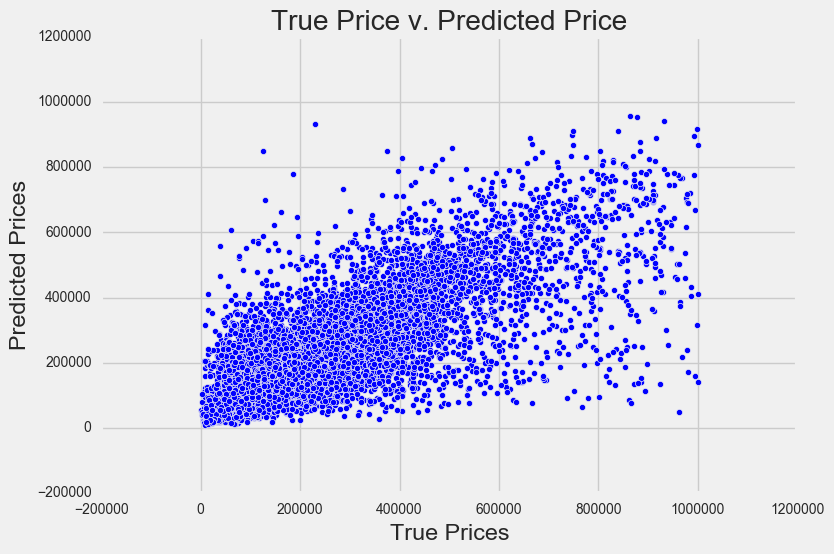

In [32]:
plt.scatter(predicted_prices.close_price, predicted_prices.predicted_price)
plt.title('True Price v. Predicted Price')
plt.xlabel('True Prices')
plt.ylabel('Predicted Prices');

# 2. Model Performance Measured in Median Relative Absolute Error

In [33]:
def median_relative_absolute_error(predicted_prices):
    
    #median of abs(predicted_price - close_price)/close_price
    predicted_price = predicted_prices['predicted_price']
    close_price = predicted_prices['close_price']
    
    MRAE = ((abs(predicted_price - close_price)) / close_price).median()
    
    return MRAE

In [34]:
median_relative_absolute_error(predicted_prices)

0.17501230431391318

## kNN Pipeline

In [35]:
def kNN_model(csv_file, data_range, k, validation_percent): #string filename, list of ints, int, percent in decimal
    
    #prepare the data
    dataframe = data_prep(csv_file, data_range[0], data_range[1])
    
    #split the data
    df_testing = train_test_split(dataframe, validation_percent)
    
    #train the data
    updated_df = find_nearest_neighbors(dataframe, df_testing, k)
    
    #predict housing prices
    predicted_prices = predict_price(updated_df, k)
    
    print('Median Relative Aboslute Error: ' + str(median_relative_absolute_error(predicted_prices)))
    
    return predicted_prices

In [36]:
kNN_model = kNN_model('data.csv', [0,1000000], 4, .2)

Median Relative Aboslute Error: 0.175012304314


In [37]:
kNN_model.head()

,index,close_price,predicted_price
0,66136,287987.778,300972.443
1,66137,403187.949,302558.597
2,66138,207511.590,244154.328
3,66139,202840.598,102058.569
4,66140,86282.363,114847.040


In [38]:
len(kNN_model) #sanity check

16535

In [39]:
kNN_model.head()

,index,close_price,predicted_price
0,66136,287987.778,300972.443
1,66137,403187.949,302558.597
2,66138,207511.590,244154.328
3,66139,202840.598,102058.569
4,66140,86282.363,114847.040


In [40]:
kNN_model.tail()

,index,close_price,predicted_price
16530,82666,187080.636,182039.742
16531,82667,76330.016,48403.165
16532,82668,149902.445,566460.263
16533,82669,117513.374,115846.796
16534,82670,80348.212,81789.646


# 3. An appropriate methodology to determine optimal k
1. One approach is to run this test set on a range of different values of k and graph the model performance based on MRAE to see which value of k is optimal. 
2. There could potentially be an approach that invovles cross-validation, but because each testing datapoint uses a different training set (the newer the home, the more training data), it wouldn't be as reliable. 
3. The first and simpler approach would work best, even in production.

# 4. Spatial or Temporal Trends in Error
1. The raw data, not including the negative closing prices, has two ostensible clusters: homes both over and under a million dollars, with homes under a million being the overwhelming majority. Not specifying the price range in the data worsens the error. It's possible that the homes over a million dollars (some are ten and other a hundred million) represent a spatial trend, where the multi-million dollar homes are of a different location than the rest. 
2. To find out temporal trends, one would plot the datetime by its respective relative absolute error. To visualize, one could group the datetime by months or seasons to see how temporal trends affects the variance in closing prices.
3. To visualize spatial trends in error, one would plot the geolocation data on a map graph and superimpose it with a color scale of respective errors.

# 5. Model Improvement
1. K-D Tree. A k-d tree would be able to spatially store the training data for faster look-up times of nearest neighbors. In turn, this will decrease testing time. Especially given that the dimensionality of this problem is low, a k-d tree is ideal. 
2. Increase features and more data. As of now, the model is simply predicting based on geolocation data. For example, it's possible that the model is predicting the price of a shack next to four mansions. To improve it, there must be more information about the homes (i.e., square feet, bedrooms, school district ratings). It's worth noting that once dimensionality increases past about twenty, locality sensitive hashing (LHS) will temper the "curse of dimensionality."
3. If possible to create an efficient algorithm, one could try to improve the distance accuracy by using the great circle equation instead of the reduced haversine equation.
4. One could explore alternatives to Shepherd's method of the inverse distance weighting scheme. For example, this model uses p=2 but it could be decided to put either a higher or lower penalty on neighbors that are further away. Other metrics for the IDW scheme would be the Łukaszyk-Karmowski metric or Modified Shepherd's method. The Modified Shepherd's method is ideal to combine with a k-d tree because this method searches for nearest neighbors within a certain sphere of the entire sample, and when coupled with a k-d tree the complexity becomes N*logN time. 

# 6. Productionizing this model
1. Everything listed under "Model Improvement."
2. The productionized model should incorporate into its algorithm an additional weight for a particular home on its neighbors that were sold more recently. 
3. Assuming that in production there will be a lot more features, it's necessary to rescale the data for features that are in different metrics. For starters, scikit-learn has a normalize() method.
4. Finally, this model should be able to handle live data. It could use an API that was written to query a database accordingly for new houses that are being added.